# Set-up

In [1]:
# Import modules
import os
import sys
import numpy as np
import pandas as pd
import torch

import seqdata as sd

import matplotlib.pyplot as plt
import seaborn as sns

from eugene import models
from eugene.models import zoo
from eugene import plot as pl

sys.path.append('/cellar/users/aklie/data/datasets/deAlmeida_DrosophilaS2_UMI-STARR-seq/bin/model_evaluation')
from eval import training_summary, scatter

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Set wd
os.chdir("/cellar/users/aklie/data/datasets/deAlmeida_DrosophilaS2_UMI-STARR-seq")

In [3]:
# cuda check
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
print(device)

cuda:0


In [4]:
# Set fold to eval on
date = "2023_12_19"
dataset = "evoaug"
model = "DeepSTARR"
target_var = "both"
train_var = "train_val"

# Set log dir
log_dir = f"models/{date}/{dataset}/{model}/{target_var}/{train_var}"
print(f"Log dir: {log_dir}")

# Set task
if target_var == "both":
    if dataset == "evoaug":
        target_var = ["target"]
    elif dataset == "seqdatasets":
        target_var = ["Dev_log2_enrichment", "Hk_log2_enrichment"]
    else:
        raise ValueError(f"Invalid dataset: {dataset}")
elif target_var == "dev":
    target_var = ["Dev_log2_enrichment"]
elif target_var == "hk":
    target_var = ["Hk_log2_enrichment"]
else:
    raise ValueError(f"Invalid target: {target_var}")

# Metrics
metric = "pearson"

Log dir: models/2023_12_19/evoaug/DeepSTARR/both/train_val


# Training curve

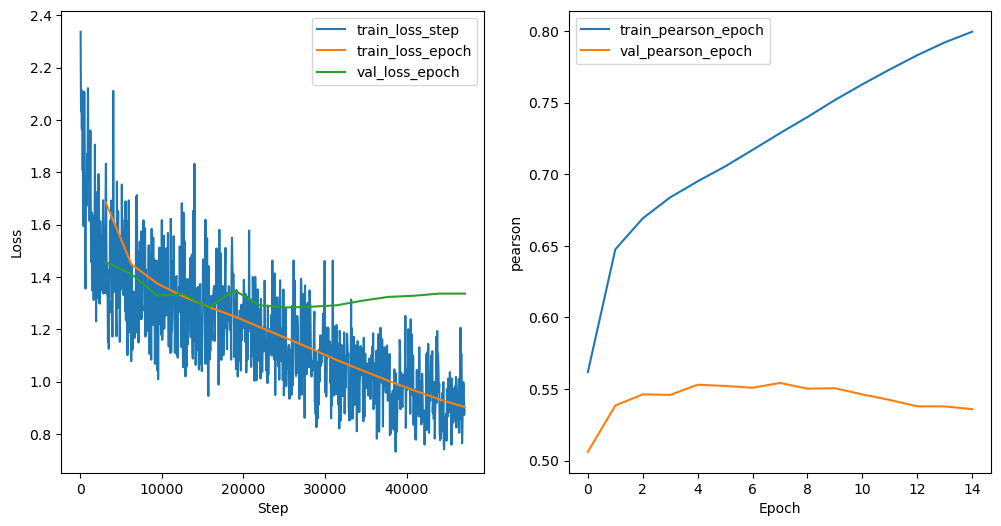

In [5]:
training_summary(
    log_path=log_dir, 
    metrics=["pearson"], 
    logger="csv", 
    figsize=(12, 6),
    save=os.path.join(log_dir, "training_summary.png")
)

# Load test SeqData

In [6]:
# Load SeqData
sdata = sd.open_zarr(f"training/2023_12_19/{dataset}/deAlmeida22_test.zarr")
sdata.load()

<xarray.Dataset>
Dimensions:  (_sequence: 41186, _ohe: 4, _length: 249, _targets: 2)
Dimensions without coordinates: _sequence, _ohe, _length, _targets
Data variables:
    ohe_seq  (_sequence, _ohe, _length) float32 1.0 1.0 0.0 1.0 ... 1.0 0.0 0.0
    target   (_sequence, _targets) float32 3.418 1.983 2.212 ... 0.6159 -1.206

In [7]:
test_seqs = torch.tensor(sdata["ohe_seq"][:10].values, dtype=torch.float32)
test_seqs.shape

torch.Size([10, 4, 249])

# Instantiate the model

In [8]:
# Instantiate architecture
arch = zoo.DeepSTARR(
    input_len=249,
    output_dim=2
)
arch(test_seqs).shape

torch.Size([10, 2])

In [10]:
module = models.SequenceModule.load_from_checkpoint(
    os.path.join(log_dir, "best_model.ckpt"),
    arch=arch,
)

[rank: 0] Global seed set to 1234


# Get predictions

In [11]:
module.to(device).eval();

In [12]:
preds = module.predict(
    sdata["ohe_seq"].values,
    batch_size=128
).cpu().numpy().squeeze()

Predicting on batches:   0%|          | 0/321 [00:00<?, ?it/s]

# Plot performance

In [13]:
# Make output directory if it doesn't exist
outdir = os.path.join(log_dir, "performance")
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [14]:
sdata

<xarray.Dataset>
Dimensions:  (_sequence: 41186, _ohe: 4, _length: 249, _targets: 2)
Dimensions without coordinates: _sequence, _ohe, _length, _targets
Data variables:
    ohe_seq  (_sequence, _ohe, _length) float32 1.0 1.0 0.0 1.0 ... 1.0 0.0 0.0
    target   (_sequence, _targets) float32 3.418 1.983 2.212 ... 0.6159 -1.206

In [16]:
target_var

['target']

In [21]:
sdata[target_var[0]]

<xarray.DataArray 'target' (_sequence: 41186, _targets: 2)>
array([[ 3.4183066 ,  1.9830812 ],
       [ 2.2115448 , -0.37998202],
       [ 3.4838314 ,  1.4348631 ],
       ...,
       [ 0.68103   , -2.1515048 ],
       [ 1.1444305 , -1.8773298 ],
       [ 0.61593497, -1.2059526 ]], dtype=float32)
Dimensions without coordinates: _sequence, _targets
Attributes:
    _FillValue:  nan

In [24]:
if dataset == "evoaug":
    # Grab preds
    dev_preds = preds[:, 0]
    hk_preds = preds[:, 1]

    # Get targets
    dev_obs = sdata[target_var[0]].values[:, 0]
    hk_obs = sdata[target_var[0]].values[:, 1]

    # Make and save df
    dev_df = pd.DataFrame({"obs": dev_obs, "pred": dev_preds})
    hk_df = pd.DataFrame({"obs": hk_obs, "pred": hk_preds})
    hk_df.to_csv(os.path.join(outdir, "hk_test_preds.csv"))
    dev_df.to_csv(os.path.join(outdir, "dev_test_preds.csv"))
elif dataset == "seqdatasets":
    # Grab preds
    dev_preds = preds[:, 0]
    hk_preds = preds[:, 1]

    # Get targets
    dev_var = target_var[0]
    hk_var = target_var[1]

    # Make and save df
    dev_df = sdata[[dev_var]].to_pandas().rename(columns={dev_var: "obs"})
    hk_df = sdata[[hk_var]].to_pandas().rename(columns={hk_var: "obs"})
    hk_df["pred"] = hk_preds
    dev_df["pred"] = dev_preds
    hk_df.to_csv(os.path.join(outdir, "hk_test_preds.csv"))
    dev_df.to_csv(os.path.join(outdir, "dev_test_preds.csv"))

In [25]:
# Plot a nice blue color
scatter(
    x=dev_df.obs,
    y=dev_df.pred,
    c="#4682B4",
    alpha=0.8,
    xlabel="Experimental activity",
    ylabel="Predicted activity",
    density=True,
    rasterized=True,
    s=5,
    save=os.path.join(outdir, "dev_test_scatter.png")
)

In [17]:
# Plot a nice blue color
scatter(
    x=hk_df.obs,
    y=hk_df.pred,
    c="#4682B4",
    alpha=0.8,
    xlabel="Experimental activity",
    ylabel="Predicted activity",
    density=True,
    rasterized=True,
    s=5,
    save=os.path.join(outdir, "hk_test_scatter.png")
)

# DONE!

---